## Group Name: Bill Greats 

### Team Members: Kumar Kishalaya, Sakshi Arya, Shiv Goel, Ruben Casas


In [17]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, normalizers, processors
from tokenizers.processors import BertProcessing
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Sequence, Lowercase, NFD, StripAccents
from tokenizers.trainers import WordLevelTrainer
from transformers import BertTokenizerFast


In [ ]:
import pandas as pd

df_final = pd.read_csv('df_final.csv')
df_final.drop(columns='Unnamed: 0',inplace=True)

In [67]:
import numpy as np

# Function to shuffle and join a list of strings
def shuffle_and_join(x):
    x = list(x)
    np.random.shuffle(x)
    return ' '.join(x)

# Apply the function to movie_name and movie_id columns
df = df_final.groupby('user_id').agg({
    'movie_name': lambda x: shuffle_and_join(x),
    'movie_id': lambda x: shuffle_and_join(map(str, x))
}).reset_index()
df.head()

,user_id,movie_name,movie_id
0,1,Fargo (1996) E.T. the Extra-Terrestrial (1982)...,3186 1836 3105 2355 531 1287 783 1907 1270 938...
1,2,Like Water for Chocolate (Como agua para choco...,368 163 1784 589 736 1537 3035 1610 380 1955 4...
2,3,Young Guns (1988) Indiana Jones and the Last C...,2470 480 1615 1259 3168 653 1291 1136 2355 130...
3,4,"Raiders of the Lost Ark (1981) Good, The Bad a...",1214 480 1036 2951 1097 1240 1198 2028 2692 34...
4,5,Being John Malkovich (1999) Bob Roberts (1992)...,1046 1449 1175 2571 162 2987 2560 2395 3260 17...


In [68]:
movie_id_list = df['movie_id'].tolist()

In [69]:
movie_id_list[0]

'3186 1836 3105 2355 531 1287 783 1907 1270 938 2797 608 3114 527 2018 1035 260 1246 1962 2918 919 1545 2398 1097 1721 2762 588 1566 2028 2804 2692 150 2294 1029 1207 594 48 2791 1 1961 1022 3408 1028 1193 595'

In [70]:
# Create a custom vocabulary from your dataset
unique_tokens = set()
for seq in movie_id_list:
    unique_tokens.update(seq.split())


In [71]:
# Initialize the tokenizer with the WordLevel model
tokenizer = Tokenizer(models.WordLevel(unk_token="[UNK]"))
tokenizer.normalizer = Sequence([NFD(), Lowercase(), StripAccents()])
tokenizer.pre_tokenizer = Whitespace()

In [72]:
# Add special tokens
special_tokens = ["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
trainer = WordLevelTrainer(vocab=list(unique_tokens), special_tokens=special_tokens)

tokenizer.train_from_iterator([unique_tokens], trainer=trainer)

Ignored unknown kwargs option vocab


In [73]:
# Post-process with BERT-specific processing
tokenizer.post_processor = BertProcessing(
    ("[SEP]", tokenizer.token_to_id("[SEP]")),
    ("[CLS]", tokenizer.token_to_id("[CLS]"))
)

# Save the tokenizer
tokenizer.save("custom_tokenizer.json")

In [74]:
# Load the tokenizer with BertTokenizerFast
tokenizer = BertTokenizerFast(tokenizer_file="custom_tokenizer.json")

# Print the size of the tokenizer to verify
print(f"Size of the tokenizer: {len(tokenizer)}")

Size of the tokenizer: 3538


In [75]:
from transformers import BertConfig, BertForMaskedLM, AdamW
import torch
from tqdm import tqdm


In [181]:
# Create a custom configuration with vocab size equal to the size of your custom tokenizer
config = BertConfig(
    vocab_size=len(tokenizer),
    hidden_size=512,
    num_hidden_layers=4,
    num_attention_heads=2,
    intermediate_size=1024,
)

# Initialize the model with the custom configuration
model = BertForMaskedLM(config)

In [182]:
movie_id_list[:3]

['3186 1836 3105 2355 531 1287 783 1907 1270 938 2797 608 3114 527 2018 1035 260 1246 1962 2918 919 1545 2398 1097 1721 2762 588 1566 2028 2804 2692 150 2294 1029 1207 594 48 2791 1 1961 1022 3408 1028 1193 595',
 '368 163 1784 589 736 1537 3035 1610 380 1955 480 590 1962 2002 2571 3095 1124 1834 1293 982 3471 457 1225 3071 1193 3255 1953 1873 2353 3030 356 1096 2501 2943 1188 2268 1957 265 3468 1954 110 318 2396 3451 1370 1210 593 349 1246 3068 1259 2067 3334 2028 1207 920 648 1198 3147 1357 3105 1945 515 3578 1544 1442 1247 2858 1196 2194 2236 3418 1527',
 '2470 480 1615 1259 3168 653 1291 1136 2355 1304 2871 2735 1394 2167 3421 1379 3552 2115 1198 2858 1378 1210 1197 2006 590 104 1196 3671 2081 1049 552 260 1266 1968 1079 1961 733']

In [183]:
inputs = tokenizer(movie_id_list, return_tensors='pt', max_length=20, truncation=True, padding='max_length')
inputs['labels'] = inputs.input_ids.detach().clone()

In [184]:
inputs['input_ids']

tensor([[   1, 2188,  779,  ..., 1573,  237,    2],
        [   1, 2680,  602,  ...,  125,  777,    2],
        [   1, 1444, 3057,  ..., 2553, 1080,    2],
        ...,
        [   1,  171,  136,  ...,    3,    3,    3],
        [   1,  408,  193,  ...,  126, 2085,    2],
        [   1,  606, 2111,  ..., 1350,  277,    2]])

In [185]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [186]:
# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 1) * \
           (inputs.input_ids != 2) * (inputs.input_ids != 3)

In [187]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

In [188]:
selection[:3]

[[2, 9, 10, 14, 15], [16, 17, 18], [7, 8, 17]]

In [189]:
for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 4

In [190]:
inputs.input_ids

tensor([[   1, 2188,    4,  ..., 1573,  237,    2],
        [   1, 2680,  602,  ...,    4,    4,    2],
        [   1, 1444, 3057,  ...,    4, 1080,    2],
        ...,
        [   1,    4,  136,  ...,    3,    3,    3],
        [   1,  408,  193,  ...,    4, 2085,    2],
        [   1,  606, 2111,  ..., 1350,  277,    2]])

In [191]:
class MoviesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [192]:
dataset = MoviesDataset(inputs)

In [193]:
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [194]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(3538, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affi

In [195]:
from transformers import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)

/Users/kumarkishalaya/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [196]:
from tqdm import tqdm  # for our progress bar

epochs = 3
loss_values = []

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        loss_values.append(loss.item())
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|                                                  | 0/1510 [00:00<?, ?it/s]/var/folders/ly/npw69p7x4lg1l7s7mm3y7twm0000gn/T/ipykernel_59420/3232924672.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████████████| 1510/1510 [00:49<00:00, 30.49it/s, loss=0.861]


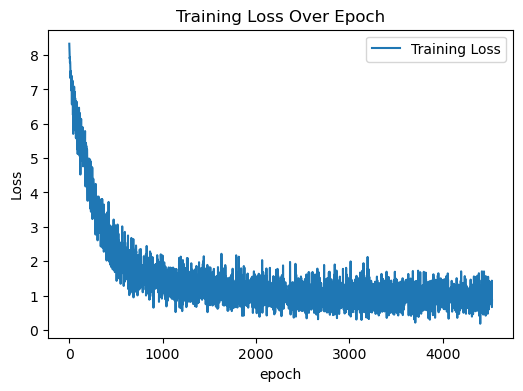

In [197]:
import matplotlib.pyplot as plt
#Plot the loss values
plt.figure(figsize=(6, 4))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epoch')
plt.legend()
plt.show()

In [198]:
# Save the model and tokenizer
model.save_pretrained("trained_bert_model")
tokenizer.save_pretrained("trained_bert_tokenizer")

('trained_bert_tokenizer/tokenizer_config.json',
 'trained_bert_tokenizer/special_tokens_map.json',
 'trained_bert_tokenizer/vocab.json',
 'trained_bert_tokenizer/added_tokens.json',
 'trained_bert_tokenizer/tokenizer.json')

In [199]:
def compute_top_k_precision(model, tokenizer, val_loader, k=10):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            for i in range(len(input_ids)):
                mask_token_indices = torch.where(input_ids[i] == tokenizer.mask_token_id)[0]
                for mask_token_index in mask_token_indices:
                    mask_token_logits = logits[i, mask_token_index, :]
                    top_k_indices = torch.topk(mask_token_logits, k).indices.tolist()

                    if labels[i, mask_token_index].item() in top_k_indices:
                        correct_predictions += 1
                    total_predictions += 1

    top_k_precision = correct_predictions / total_predictions if total_predictions > 0 else 0
    return top_k_precision


In [200]:
# Validation phase
top_5_precision = compute_top_k_precision(model, tokenizer, loader, k=5)
print(f"Epoch {epoch} - Top-5 Precision: {top_5_precision:.4f}")

Validation:   0%|                                      | 0/1510 [00:00<?, ?it/s]/var/folders/ly/npw69p7x4lg1l7s7mm3y7twm0000gn/T/ipykernel_59420/3232924672.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Validation: 100%|██████████████████████████| 1510/1510 [00:10<00:00, 148.08it/s]

Epoch 2 - Top-5 Precision: 0.0443


def get_top_k_predictions_for_token(model, tokenizer, input_ids_str, movie_name_to_id, id_to_movie_name, id_to_genre, top_k=10):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Convert input string of movie IDs to a list of integers
        input_ids = [int(movie_id) for movie_id in input_ids_str.split(", ")]
        
        # Add the [MASK] token at the end
        input_ids.append(tokenizer.mask_token_id)
        
        # Convert to tensor and add batch dimension
        input_ids = torch.tensor([input_ids])
        attention_mask = torch.ones(input_ids.shape)
        
        # Get predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Get the position of the [MASK] token
        mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
        
        # Get the logits corresponding to the [MASK] token and apply softmax
        mask_token_logits = logits[0, mask_token_index, :]
        softmax = torch.nn.Softmax(dim=-1)
        probs = softmax(mask_token_logits)
        
        # Get the top k predictions
        top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
        
        # Map the predictions to movie names and genres
        predictions = []
        for idx in top_k_indices[0]:
            token_id = idx.item()
            if token_id in id_to_movie_name:
                movie_name = id_to_movie_name[token_id]
                genre = id_to_genre.get(token_id, "Unknown Genre")
                predictions.append({"Movie": movie_name, "Genre": genre})
            else:
                predictions.append({"Movie": f"Unknown ID: {token_id}", "Genre": "Unknown Genre"})
        
        # Convert predictions to DataFrame
        df_predictions = pd.DataFrame(predictions)
        
        return df_predictions

In [168]:
movie_name_to_id = df_final.set_index('movie_name')['movie_id'].to_dict()
id_to_movie_name = df_final.set_index('movie_id')['movie_name'].to_dict()
id_to_genre = df_final.set_index('movie_id')['genre'].to_dict()

input_ids_str = '1193'
df_predictions = get_top_k_predictions_for_token(model, tokenizer, input_ids_str, movie_name_to_id, id_to_movie_name, id_to_genre)
print("Top 3 predictions for the movie token:")
pd.DataFrame(df_predictions, columns=['movie_name','genre'])


In [201]:
# Function to load the model and tokenizer
def load_model_and_tokenizer(model_path, tokenizer_path):
    model = BertForMaskedLM.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    return model, tokenizer

import torch
from transformers import BertTokenizer, BertForMaskedLM

def get_top_k_predictions(model, tokenizer, input_ids_str, id_to_movie_name, id_to_genre, top_k=10):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Convert input string of movie IDs to a list of integers
        input_ids = [int(movie_id) for movie_id in input_ids_str.split(", ")]
        
        # Add the [MASK] token at the end
        input_ids.append(tokenizer.mask_token_id)
        
        # Convert to tensor and add batch dimension
        input_ids = torch.tensor([input_ids])
        attention_mask = torch.ones(input_ids.shape)
        
        # Get predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Get the position of the [MASK] token
        mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
        
        # Get the logits corresponding to the [MASK] token and apply softmax
        mask_token_logits = logits[0, mask_token_index, :]
        softmax = torch.nn.Softmax(dim=-1)
        probs = softmax(mask_token_logits)
        
        # Get the top k predictions
        top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
        
        # Map the predictions to movie names and genres
        predictions = []
        for idx in top_k_indices[0]:
            token_id = idx.item()
            if token_id in id_to_movie_name:
                movie_name = id_to_movie_name[token_id]
                genre = id_to_genre.get(token_id, "Unknown Genre")
                predictions.append((movie_name, genre))
            else:
                predictions.append((f"Unknown ID: {token_id}", "Unknown Genre"))
        
        return predictions


In [210]:
input_ids_str = 'Shawshank Redemption, The (1994)'
predictions = get_top_k_predictions(model, tokenizer, input_ids_str, id_to_movie_name, id_to_genre)
pd.DataFrame(predictions)


,0,1
0,Illtown (1996),Crime|Drama
1,Father of the Bride Part II (1995),Comedy
2,Face/Off (1997),Action|Sci-Fi|Thriller
3,"Preacher's Wife, The (1996)",Drama
4,We're Back! A Dinosaur's Story (1993),Animation|Children's
5,Unknown ID: 1742,Unknown Genre
6,Small Wonders (1996),Documentary
7,"Outsiders, The (1983)",Drama
8,Nine Months (1995),Comedy
9,Unforgettable (1996),Thriller


In [203]:
df_final.sample(n=5)

,user_id,movie_name,movie_id,genre
468578,4921,Central Station (Central do Brasil) (1998),2357,Drama
329697,3512,"Shawshank Redemption, The (1994)",318,Drama
461881,4842,"Sixth Sense, The (1999)",2762,Thriller
63860,714,Young Guns II (1990),1379,Action|Comedy|Western
431748,4506,"Fabulous Baker Boys, The (1989)",3684,Drama|Romance
